In [1]:
!pip install tensorflow 
!pip install keras 

In [2]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# on-the-fly data augumentation applied to expand training dataset size 

train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

#rotation_range: Degree range for random rotations. 360 degrees chosen since product is a round object.
#width_shift_range: Fraction range of the total width to be shifted.
#height_shift_range: Fraction range of the total height to be shifted.
#shear_range: Degree range for random shear in a counter-clockwise direction.
#zoom_range: Fraction range for random zoom.
#horizontal_flip and vertical_flip are set to True for randomly flip image horizontally and vertically.
#brightness_range: Fraction range for picking a brightness shift value.
#rescale: Eescale the pixel values to be in range 0 and 1.
#validation_split: Reserve 20% of the training data for validation, and the rest 80% for model fitting.

In [4]:
IMAGE_DIR = "casting_data" #importing dataset from extracted zip file 
IMAGE_SIZE = (300, 300) # dimension of image 
BATCH_SIZE = 64 # Number of images loaded and trained at one time 
SEED_NUMBER = 123 # ensuring reproductibility 

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},
                shuffle = True,
                seed = SEED_NUMBER) # This dictionary holds parameters like image size, color mode, and batch config for training/validation data loading.

train_dataset = train_generator.flow_from_directory(
    directory = IMAGE_DIR + "/train",
    **gen_args
) #splitting dataset for training purposes from main dataset
validation_dataset = train_generator.flow_from_directory(
    directory = IMAGE_DIR + "/test",
    **gen_args
)#splitting dataset for testing purposes from main dataset

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [5]:
# Create a new test generator (no data augmentation)
test_generator = ImageDataGenerator(rescale=1./255)

# Load test dataset from the correct folder
test_dataset = test_generator.flow_from_directory(
    directory="casting_data/test",
    target_size=IMAGE_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# no data augumentation is performed on the testing dataset 

Found 715 images belonging to 2 classes.


In [6]:
image_data = []

#looping through each dataset along with its labels
for dataset, typ in zip([train_dataset, validation_dataset, test_dataset], ["train", "validation", "test"]):
    for name in dataset.filenames: # loop for each file name in the current dataset
        parts = name.replace('\\', '/').split('/') # replacing double slashes in filepath with single slashes and splitting path into folder (path) and filename
        #checking for proper class/filename structure 
        if len(parts) >= 2:
            image_data.append({
                "data": typ, # identifying type of split : train, test or validation
                "class": parts[0], # class label ( ex: ok_front, def_front)
                "filename": parts[1] # Actual Image file name 
            }) # satistfied metadata of images added as elements of image_data
        else:
            print(f" Skipping invalid path: {name}")

image_df = pd.DataFrame(image_data) #creating dataframe through metadata of images stored in image_data list

#creating a cross-tabulation table/summary table showing class distribution across each dataset split 
data_crosstab = pd.crosstab(
    index=image_df["data"],
    columns=image_df["class"],
    margins=True,
    margins_name="Total"
)

print(data_crosstab)


class       def_front  ok_front  Total
data                                  
test              453       262    715
train            3758      2875   6633
validation        453       262    715
Total            4664      3399   8063


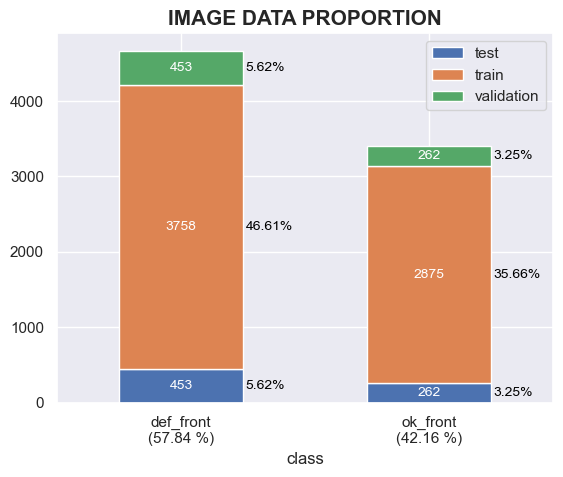

In [7]:
# Get the total number of images from the last row and column of the crosstab
total_image = data_crosstab.iloc[-1,-1]

# Create a stacked bar chart from the crosstab data (excluding totals row and column)
# Transpose the data to have categories as x-axis
ax = data_crosstab.iloc[:-1,:-1].T.plot(kind = "bar", stacked = True, rot = 0)

# List to store percentage values for later use
percent_val = []

# Loop through each rectangle (bar segment) in the plot
for rect in ax.patches:
    height = rect.get_height()  # Get the height of the bar segment
    width = rect.get_width()    # Get the width of the bar segment
    percent = 100*height/total_image  # Calculate percentage of total

    # Add text showing the count inside each bar segment
    ax.text(rect.get_x() + width - 0.25, 
            rect.get_y() + height/2, 
            int(height),  # Display the actual count
            ha = 'center',
            va = 'center',
            color = "white",
            fontsize = 10)
    
    # Add text showing the percentage next to each bar segment
    ax.text(rect.get_x() + width + 0.01, 
            rect.get_y() + height/2, 
            "{:.2f}%".format(percent),  # Format percentage with 2 decimal places
            ha = 'left',
            va = 'center',
            color = "black",
            fontsize = 10)
    
    # Store the percentage for later use
    percent_val.append(percent)

# Get and set the legend for the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)

# Calculate the total percentage for the 'def_front' category (every other percentage starting from index 0)
percent_def = sum(percent_val[::2])

# Set custom x-axis labels with calculated percentages
ax.set_xticklabels(["def_front\n({:.2f} %)".format(percent_def), "ok_front\n({:.2f} %)".format(100-percent_def)])

# Add a title to the plot
plt.title("IMAGE DATA PROPORTION", fontsize = 15, fontweight = "bold")

# Display the plot
plt.show()

In [8]:
mapping_class = {0: "ok", 1: "defect"}
print(mapping_class) 
#creating mapping_class dictonary to denote the class labels in binary

{0: 'ok', 1: 'defect'}


In [9]:
# function definition to visualise dataset with titles
def visualizeImageBatch(dataset, title):
    # Get a batch of images and labels from the dataset iterator
    images, labels = next(iter(dataset))
    # Reshape images to proper dimensions (batch_size x height x width)
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    # Create a figure with 8x8 subplots for displaying images
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    # Iterate through each subplot, image, and label
    for ax, img, label in zip(axes.flat, images, labels):
        # Display the image in grayscale
        ax.imshow(img, cmap = "gray")
        # Remove axis ticks and borders
        ax.axis("off")
        # Set the title of each subplot to the class name corresponding to the label
        ax.set_title(mapping_class[label], size = 20)

    # Adjust spacing between subplots
    plt.tight_layout()
    # Add a main title to the entire figure
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    # Display the figure
    plt.show()
    
    # Return the batch of images for potential further processing
    return images

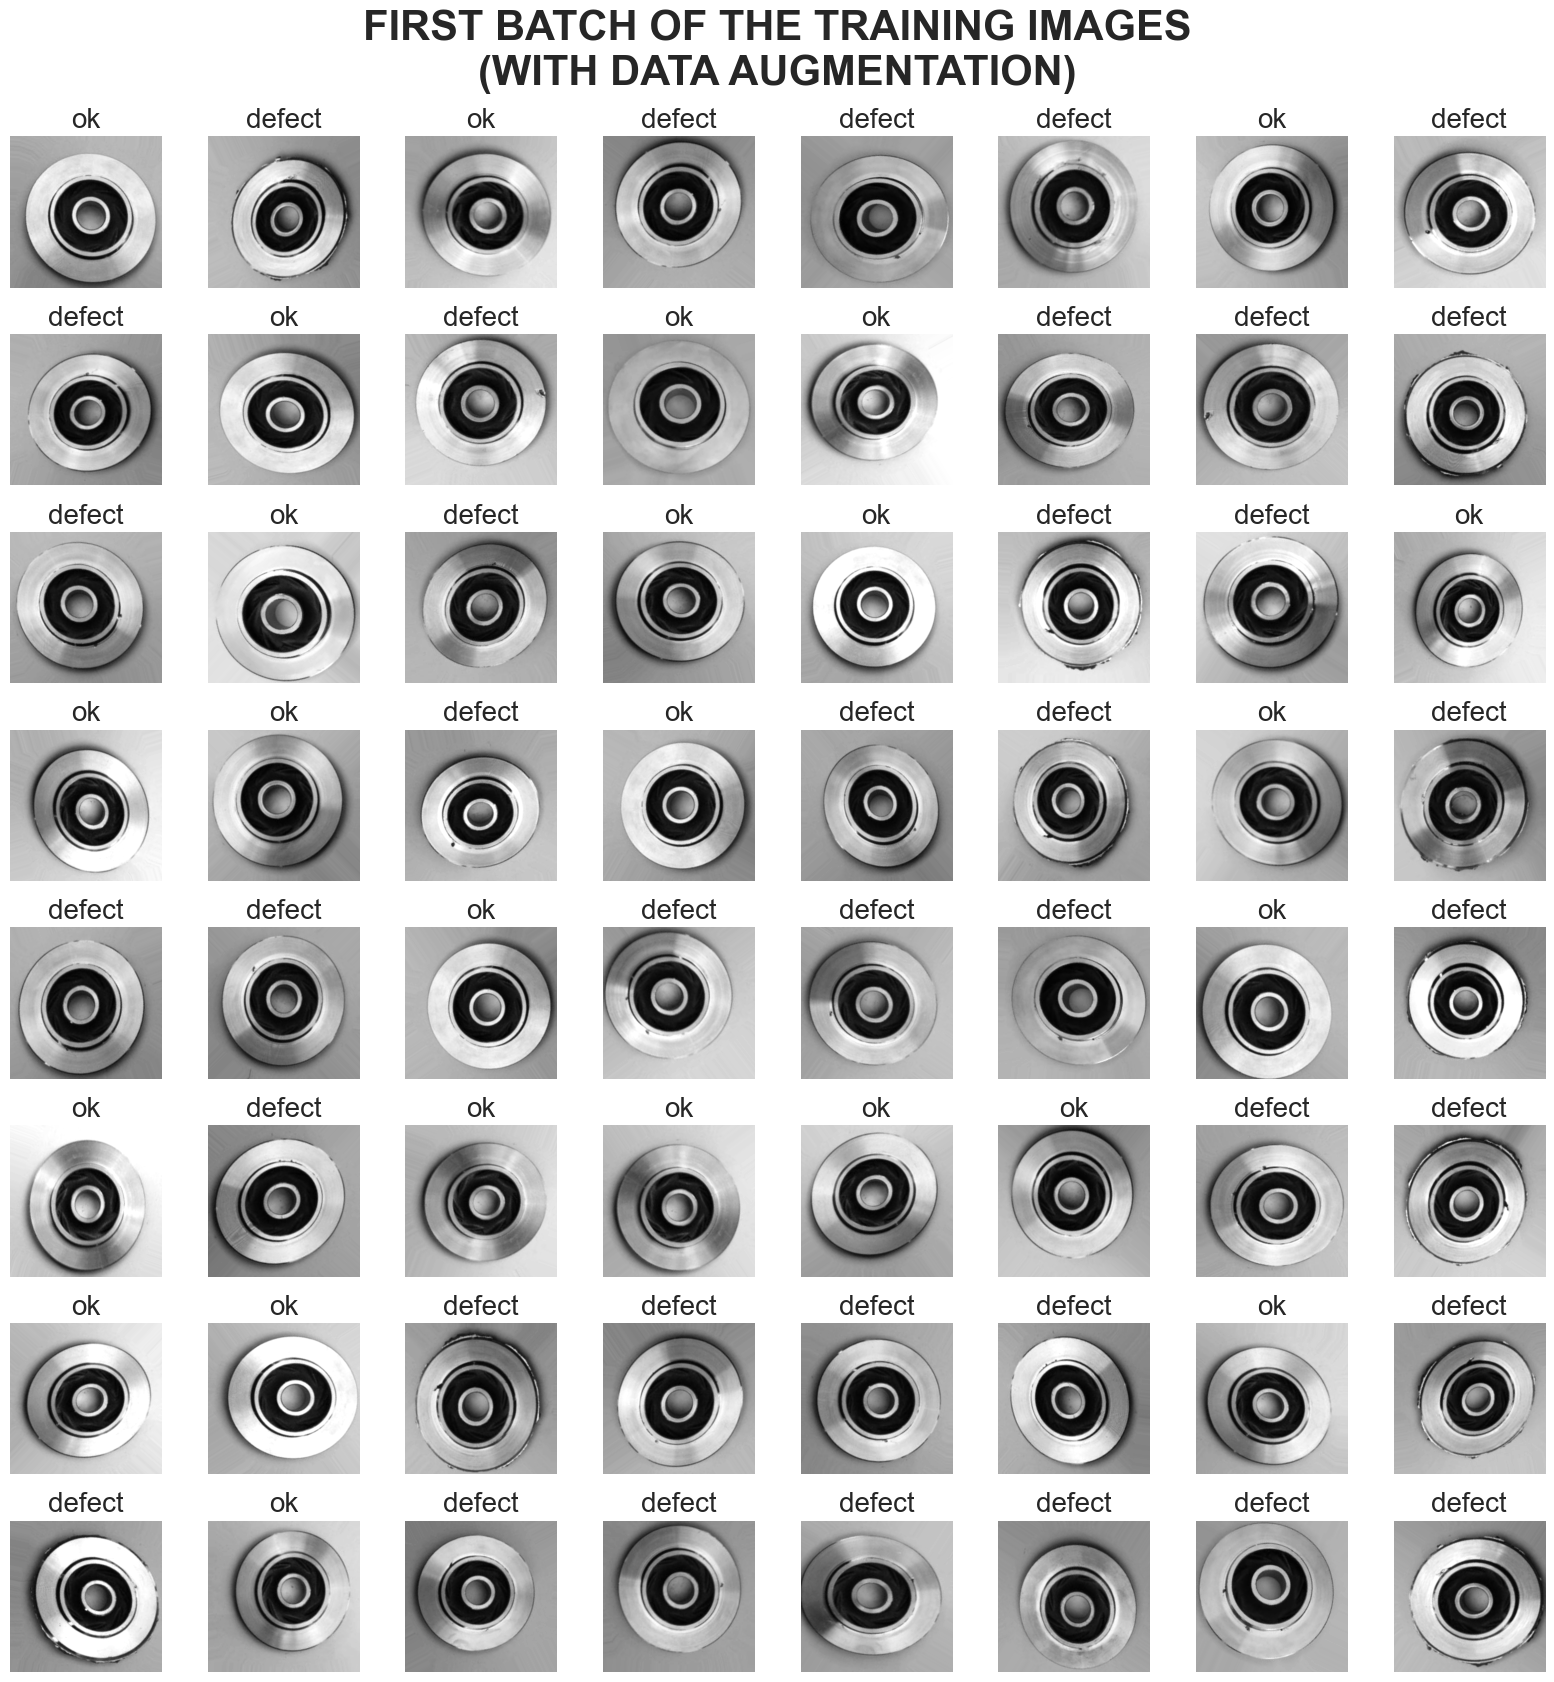

In [10]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")
#visualising images from training dataset using user-defined function

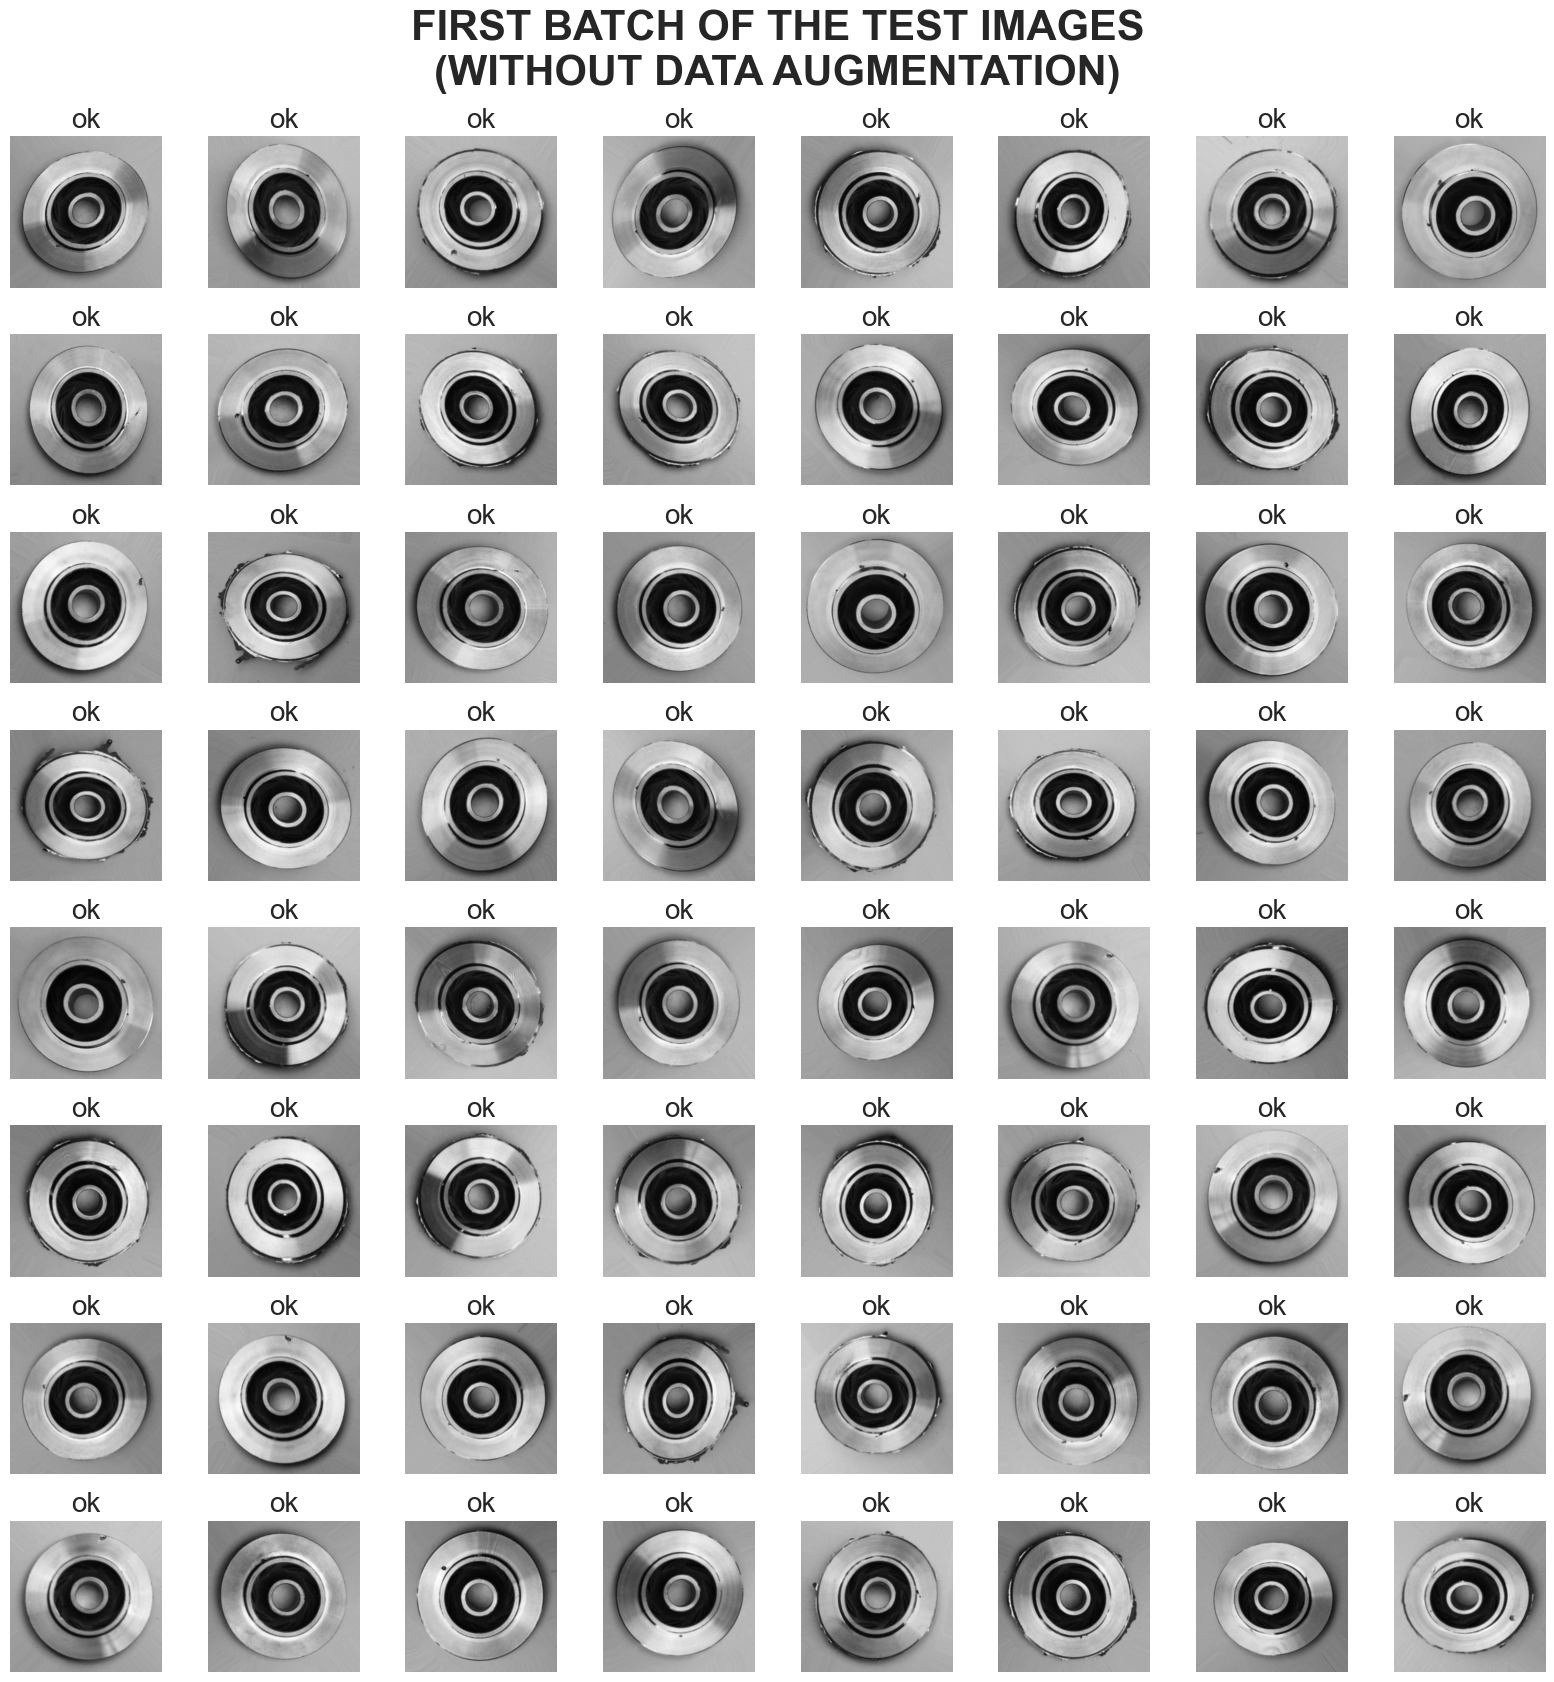

In [11]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")
#visualizing images from testing dataset using user-defined function

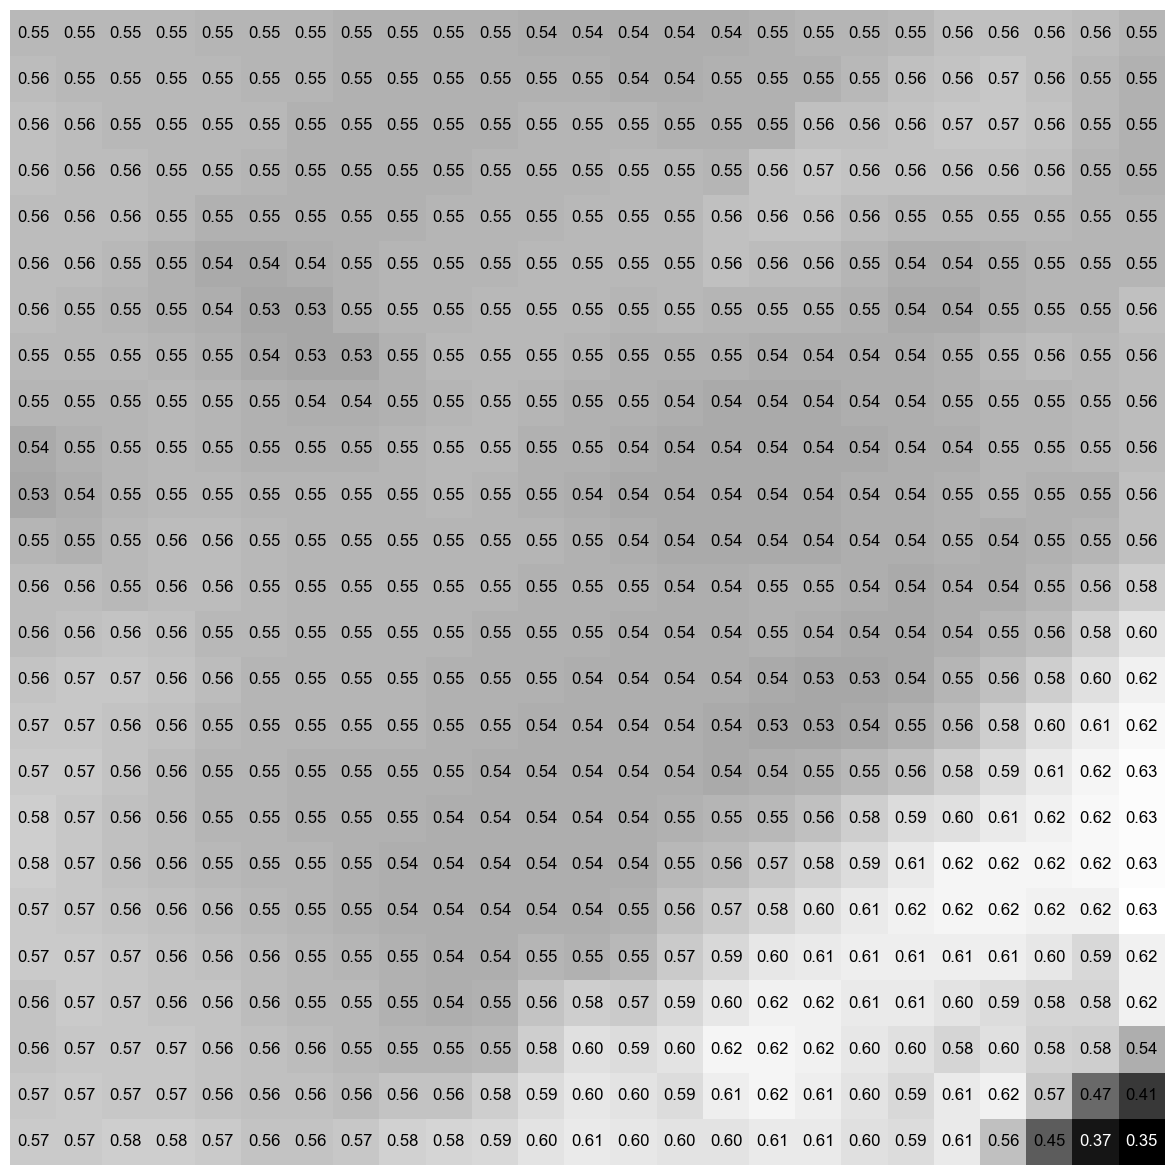

In [12]:
# Extract a 25x25 pixel region from the 5th training image
img = np.squeeze(train_images[4])[75:100, 75:100]

# Create a figure with specified size
fig = plt.figure(figsize = (15, 15))
# Add a subplot to the figure
ax = fig.add_subplot(111)
# Display the image in grayscale
ax.imshow(img, cmap = "gray")
# Hide the axis
ax.axis("off")

# Get the width and height of the image
w, h = img.shape
# Loop through each pixel in the image
for x in range(w):
    for y in range(h):
        # Get the pixel value at position (x,y)
        value = img[x][y]
        # Annotate each pixel with its value (formatted to 2 decimal places)
        # Choose text color based on pixel intensity for better visibility
        ax.annotate("{:.2f}".format(value), xy = (y,x),
                    horizontalalignment = "center",
                    verticalalignment = "center",
                    color = "white" if value < 0.4 else "black")

In [13]:
model = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

model.summary()

C:\Users\raajg\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 149, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 676,945 (2.58 MB)

 Trainable params: 676,945 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
#specifying how the model backpropagates or update the weights after each batch feed-forward

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#checking the availability of GPU

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16978265659973540976
xla_global_id: -1
]


In [16]:
STEPS = 150

checkpoint = ModelCheckpoint("cnn_casting_inspection_model.keras",
                             verbose=1,
                             save_best_only=True,
                             monitor="val_loss")

model.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=STEPS,
    epochs=25,
    validation_steps=STEPS,
    callbacks=[checkpoint],
    verbose=1
)

#model fitting of the CNN Architecture 

C:\Users\raajg\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
104/150 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.5421 - loss: 0.7048

C:\Users\raajg\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.60256, saving model to cnn_casting_inspection_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.5547 - loss: 0.6949 - val_accuracy: 0.6629 - val_loss: 0.6026
Epoch 2/25
104/150 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6735 - loss: 0.5938
Epoch 2: val_loss improved from 0.60256 to 0.50938, saving model to cnn_casting_inspection_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 882ms/step - accuracy: 0.6781 - loss: 0.5885 - val_accuracy: 0.7189 - val_loss: 0.5094
Epoch 3/25
104/150 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7347 - loss: 0.5170
Epoch 3: val_loss improved from 0.50938 to 0.46354, saving model to cnn_casting_inspection_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 868ms/step - accuracy: 0.7378 - loss: 0.5119 - val_accuracy: 0.7441 - val_loss: 0.4635
Epoch 4/25
104/150 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7907 - loss: 0.4323
Epoch 4: val_loss improved from 0.46354 to 0.31909, saving model to cnn_cast

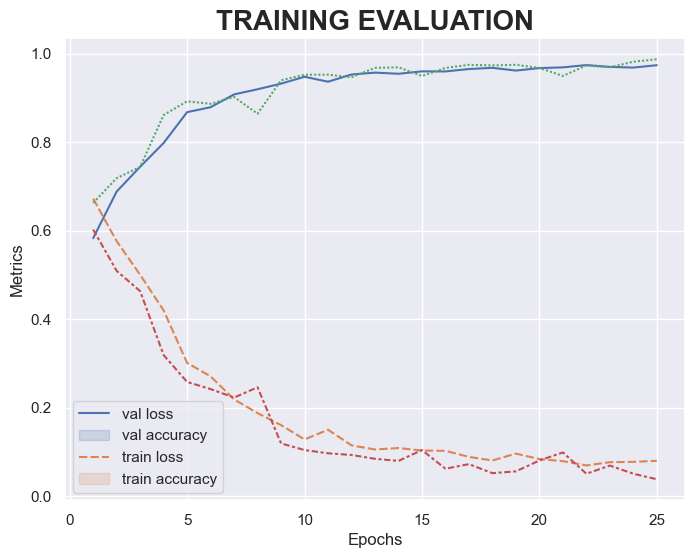

In [17]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()
# plotting loss and accuracy metrics for train and validation data

In [18]:
best_model = load_model("cnn_casting_inspection_model.keras")
#testing model with unseen and unaugumented images 

In [19]:
y_pred_prob = best_model.predict(test_dataset, verbose=1)
#The output of the prediction is in the form of probability. 
#We use THRESHOLD = 0.5 to separate the classes. 
#If the probability is greater or equal to the THRESHOLD, then it will be classified as defect, otherwise ok.

C:\Users\raajg\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


In [20]:
# Define threshold for binary classification
THRESHOLD = 0.5
# Convert probability predictions to binary class predictions using the threshold
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
# Get the true class labels from the test dataset
y_true_class = test_dataset.classes[test_dataset.index_array]

# Create and display a confusion matrix as a DataFrame with multi-level indexing
# - Rows represent actual classes (ok/defect)
# - Columns represent predicted classes (ok/defect)
pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

Predicted       
                     ok defect
Actual ok             0    453
       defect       260      2

In [21]:
# Generate a classification report comparing true labels (y_true_class) with predicted labels (y_pred_class)
# The report includes precision, recall, f1-score, and support metrics for each class
# digits=4 sets the number of decimal places to display in the report
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       453
           1     0.0044    0.0076    0.0056       262

    accuracy                         0.0028       715
   macro avg     0.0022    0.0038    0.0028       715
weighted avg     0.0016    0.0028    0.0020       715



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


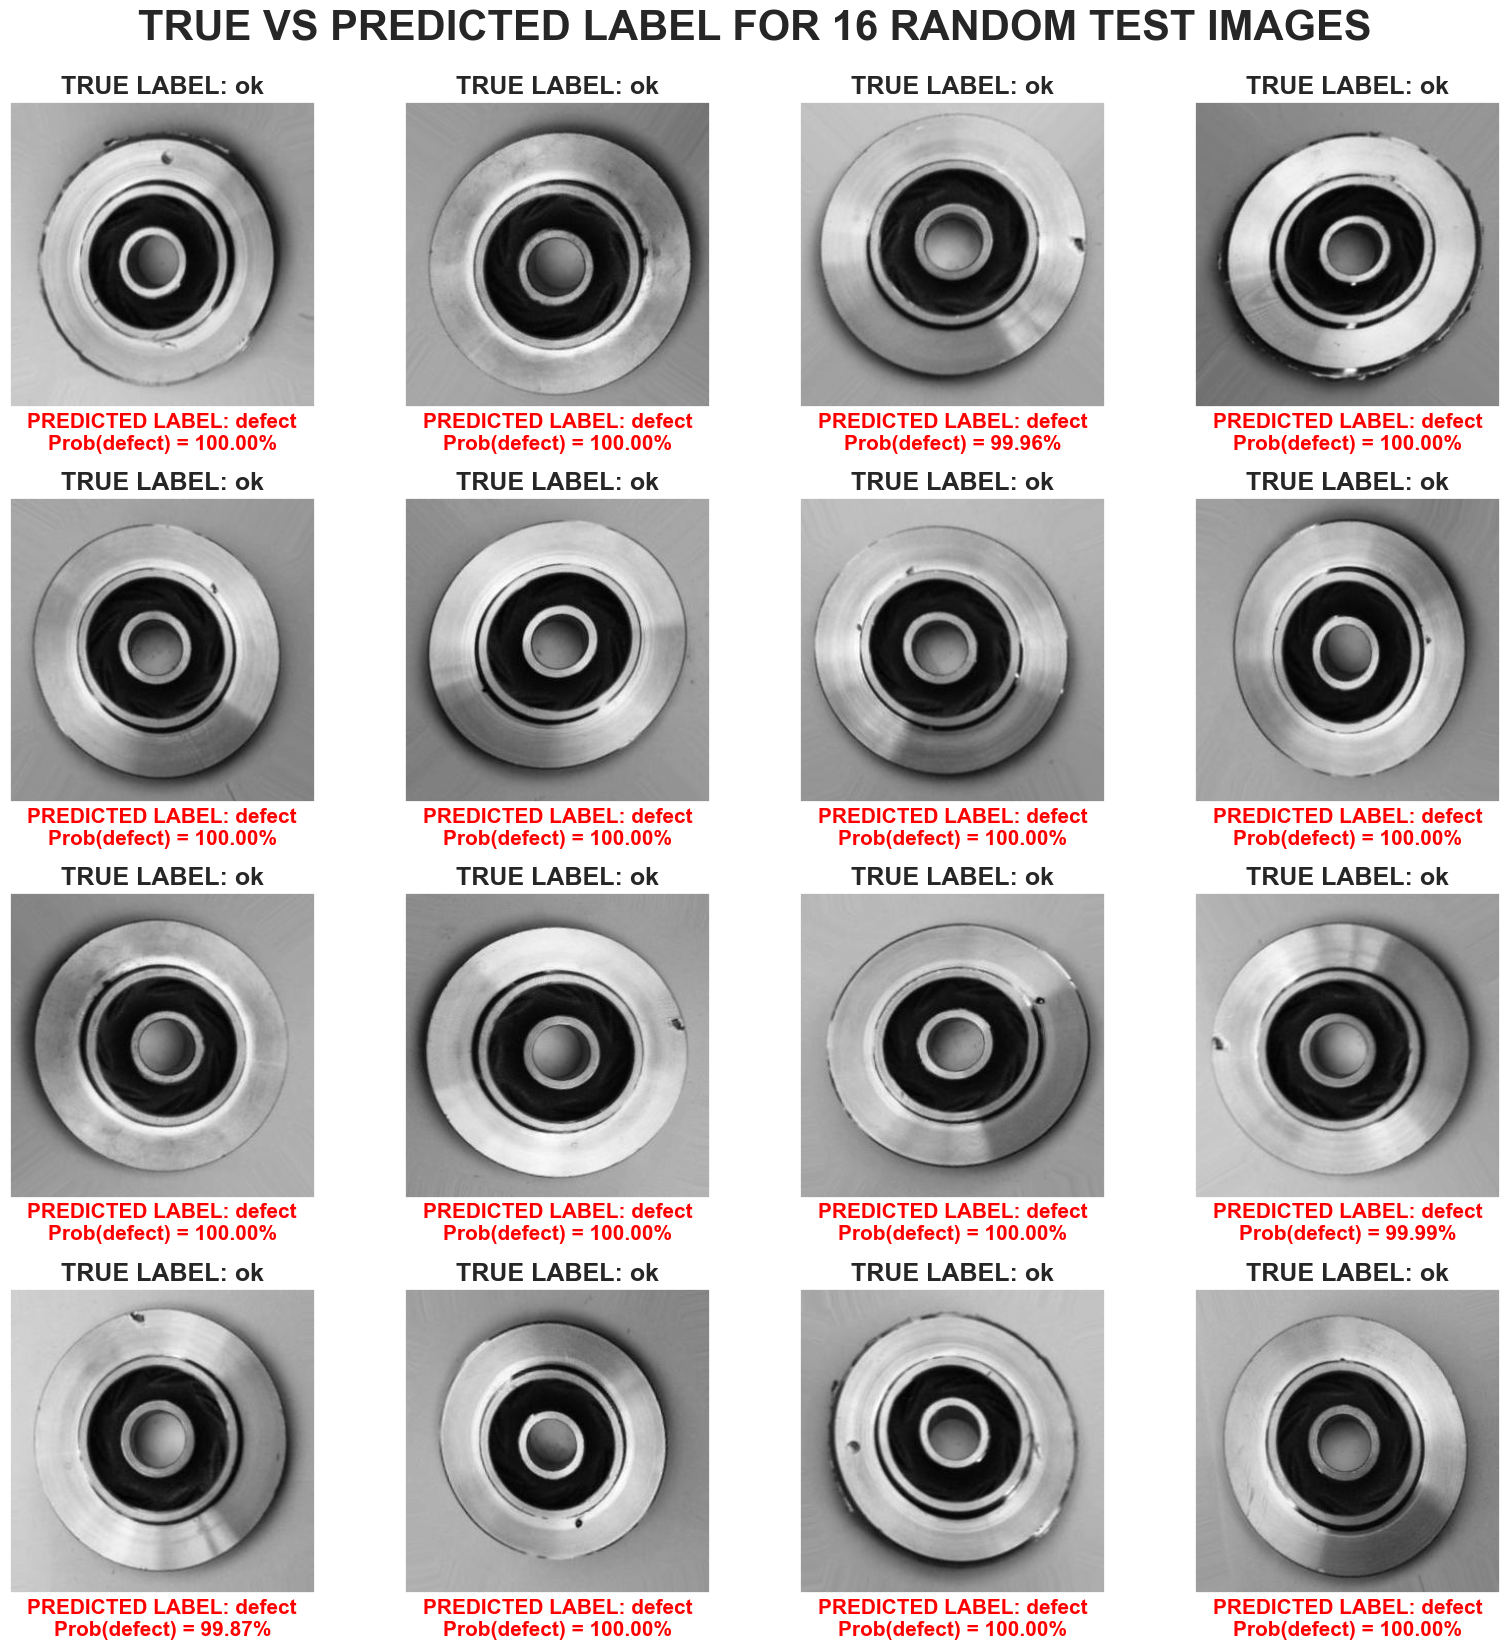

In [22]:
# Get a batch of test images and labels
images, labels = next(iter(test_dataset))
# Reshape images to the expected dimensions
images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
# Create a 4x4 grid of subplots for displaying images
fig, axes = plt.subplots(4, 4, figsize=(16,16))

# Loop through each subplot, image, and label
for ax, img, label in zip(axes.flat, images, labels):
    # Display the image in grayscale
    ax.imshow(img, cmap = "gray")
    # Convert numeric label to class name (e.g., "defect" or "no_defect")
    true_label = mapping_class[label]
    
    # Make prediction on the current image
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    # Convert prediction probability to class label using threshold
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    # Calculate probability percentage for the predicted class
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    # Set the title to show the true label
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    # Set the x-label to show prediction and confidence, colored by correctness
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    # Remove tick marks from axes
    ax.set_xticks([])
    ax.set_yticks([])
    
# Adjust spacing between subplots
plt.tight_layout()
# Add a main title for the entire figure
fig.suptitle("TRUE VS PREDICTED LABEL FOR 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
# Display the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


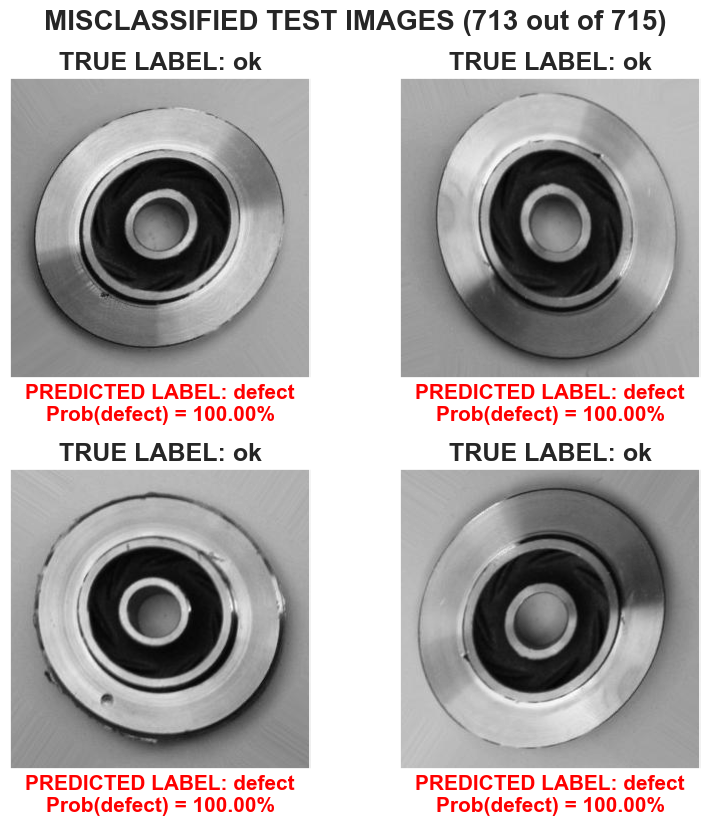

In [23]:
# Find indices of misclassified samples
misclassify_pred = np.nonzero(y_pred_class != y_true_class)[0]

# Create a 2x2 grid of subplots to display misclassified images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Loop through each subplot and display a misclassified image
for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    # Get the batch containing the misclassified image
    images, labels = test_dataset[batch_num]
    img = images[image_num]
    # Display the image in grayscale
    ax.imshow(img.reshape(*IMAGE_SIZE), cmap = "gray")
    
    # Get the true label for this image
    true_label = mapping_class[labels[image_num]]
    # Get model's prediction probability for this image
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    # Convert probability to class label using threshold
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    # Calculate probability percentage for the predicted class
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    # Set title to show the true label
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    # Set xlabel to show prediction and confidence, colored by correctness
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    # Remove axis ticks for cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    
# Adjust layout and add overall title
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(y_true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step


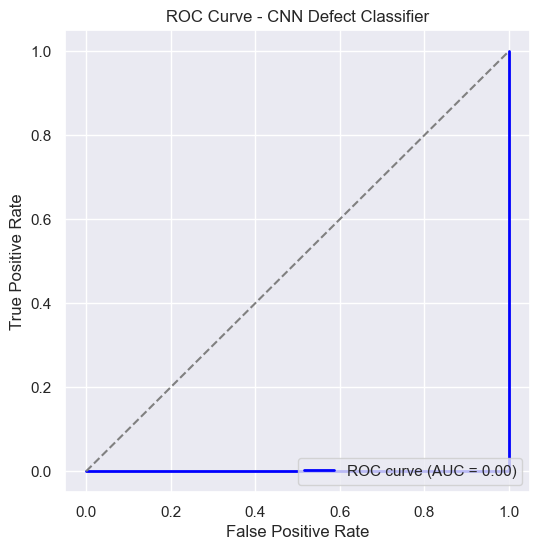

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities
y_true = test_dataset.classes
y_pred_prob = best_model.predict(test_dataset)

# ROC calculation
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Defect Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

